In [278]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [279]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades = oportunidades.dropna()
oportunidades["Moneda_Convertida"] = (oportunidades['ASP'] / oportunidades['ASP_(converted)'])
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.000000
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.000000
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,2016,NaT,0,USD,13200.0,USD,6422400.6,Closed Won,Prod_Category_A_None,1.000000
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,12194000.0,JPY,12194000.0,Closed Won,Prod_Category_A_None,111.229165
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,11959500.0,JPY,11959500.0,Closed Won,Prod_Category_A_None,111.229165
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,2016,NaT,0,JPY,17537000.0,JPY,17537000.0,Closed Won,Prod_Category_A_None,111.229477


In [280]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.0


In [281]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000,2.232794e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.000000,2.232794e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,NaT,0,USD,11961.6,USD,0.0,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,NaT,1,JPY,38976000.0,JPY,38976000.0,Closed Lost,Prod_Category_A_None,111.229550,5.688996e+07
9721,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,NaT,1,JPY,56028000.0,JPY,56028000.0,Closed Lost,Prod_Category_A_None,111.229326,5.688996e+07
9722,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,NaT,0,JPY,7660800.0,JPY,7660800.0,Closed Lost,Prod_Category_A_None,111.231449,5.688996e+07
9723,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,NaT,0,JPY,825000.0,JPY,825000.0,Closed Won,Prod_Category_A_None,111.230206,5.688996e+07


In [282]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9721,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9722,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9723,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04


In [283]:
#Encoding de las regiones en base al total amount
encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor,Encoding_Territorio,Encoding_Region
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14857,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,31762.5,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9721,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9722,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9723,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06


In [284]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'Moneda_Convertida' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')

In [285]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Territorio,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9721,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9722,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9723,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0


In [286]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2.250980e+06,1.000000,0,0,0,0,0,1,0,2.245889e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2.250980e+06,1.000000,0,0,0,0,0,1,0,2.245889e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9721,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9722,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9723,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06


In [287]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.000000,0,0,0,0,1,0,0,2.245889e+06,69490.525
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,1.000000,0,0,0,0,1,0,0,2.245889e+06,69490.525
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.884131,0,0,0,0,1,0,0,8.585832e+05,69490.525
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.884131,0,0,0,0,1,0,0,1.240120e+06,69490.525
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,1.000000,0,0,0,0,0,1,0,9.806871e+05,69490.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,2197.250
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,369.600
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,2274.300
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,3456.000


In [288]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,8.585832e+05,69490.525,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.240120e+06,69490.525,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,69490.525,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.079523e+05,2197.250,1,0,0,0,0,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.079523e+05,369.600,1,0,0,0,0,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.079523e+05,2274.300,1,0,0,0,0,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.079523e+05,3456.000,1,0,0,0,0,0,0


In [289]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,None,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,0,1,0,0,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,0,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,0,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,0,1,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,0,1,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,0,1,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,0,1,0,0


In [290]:
#Obtenemos el año de creación de la oportunidad como columna.
oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Año_Por_Mes'] = oportunidades['Opportunity_Created_Year'] \
    * oportunidades['Opportunity_Created_Month']
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,1,0,0,0,0,2015,12,24180
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,1,0,0,0,0,2016,4,8064
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,1,0,0,0,0,0,0,2017,12,24204
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,1,0,0,0,0,0,0,2018,1,2018
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,1,2017,6,12102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,1,0,0,2017,12,24204
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,1,0,0,2018,3,6054
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,1,0,0,2018,4,8072
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,1,0,0,2018,6,12108


In [291]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
    'objective':'reg:logistic',
    'max_depth':7,
    'n_estimators':450,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.001,
    #'gamma':0.2
}

params2 = {
    'objective':'reg:logistic',
    'max_depth':8,
    'n_estimators':350,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.01,
    #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
                subsample = params['subsample'])

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], alpha = params2['alpha'], n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'])
cat_reg = CatBoostRegressor(border_count = 6, depth = 8, iterations = 1000, l2_leaf_reg = 1, \
                            learning_rate = 0.012, random_strength = 0.9)

y_train = oportunidades['Stage']
oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})
# std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std'})
# std_deviation_amounts.columns = ['TRF_Std']
# std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                       'TRF': 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean','Stage':'max',
                                                      'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
                                                      'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
                                                      'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                      'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})

x_train = x_train.reset_index()
#x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
#x_train['Total_Amount_Std'] = x_train['Total_Amount_Std'].replace({np.nan:0})
x_train['Total_Amount'] = (x_train['Total_Amount'] / x_train['Encoding_Moneda']) 
x_train['Total_Taxable_Amount'] = (x_train['Total_Taxable_Amount'] / x_train['Encoding_Moneda']) 
x_train['Diferencia_Amounts'] = (x_train['Total_Amount'] - x_train['Total_Taxable_Amount'])
x_train = x_train.drop(columns = ['Encoding_Moneda'])
#x_train['Total_Tax_Amount_Std'] = x_train['Total_Tax_Amount_Std'].replace({np.nan:0})
#x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})

<ipython-input-291-254b07c40ee7>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [292]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

cat_reg.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

0:	learn: 0.4913707	total: 2.9ms	remaining: 2.9s
1:	learn: 0.4893718	total: 5.38ms	remaining: 2.69s
2:	learn: 0.4875348	total: 7.74ms	remaining: 2.57s
3:	learn: 0.4856305	total: 10.2ms	remaining: 2.54s
4:	learn: 0.4838581	total: 12.7ms	remaining: 2.53s
5:	learn: 0.4820957	total: 15.3ms	remaining: 2.53s
6:	learn: 0.4803461	total: 17.9ms	remaining: 2.54s
7:	learn: 0.4786260	total: 20.3ms	remaining: 2.52s
8:	learn: 0.4768982	total: 22.8ms	remaining: 2.51s
9:	learn: 0.4751911	total: 25.5ms	remaining: 2.53s
10:	learn: 0.4735699	total: 28.2ms	remaining: 2.53s
11:	learn: 0.4719037	total: 30.5ms	remaining: 2.51s
12:	learn: 0.4707410	total: 32.3ms	remaining: 2.45s
13:	learn: 0.4691114	total: 36.5ms	remaining: 2.57s
14:	learn: 0.4675998	total: 39ms	remaining: 2.56s
15:	learn: 0.4659807	total: 41.7ms	remaining: 2.56s
16:	learn: 0.4645300	total: 44.3ms	remaining: 2.56s
17:	learn: 0.4630412	total: 46.9ms	remaining: 2.56s
18:	learn: 0.4616418	total: 49.3ms	remaining: 2.54s
19:	learn: 0.4601565	total

169:	learn: 0.3809581	total: 512ms	remaining: 2.5s
170:	learn: 0.3808001	total: 515ms	remaining: 2.5s
171:	learn: 0.3806027	total: 519ms	remaining: 2.5s
172:	learn: 0.3804127	total: 522ms	remaining: 2.5s
173:	learn: 0.3802404	total: 526ms	remaining: 2.5s
174:	learn: 0.3801073	total: 529ms	remaining: 2.49s
175:	learn: 0.3798935	total: 532ms	remaining: 2.49s
176:	learn: 0.3797342	total: 535ms	remaining: 2.49s
177:	learn: 0.3796096	total: 538ms	remaining: 2.48s
178:	learn: 0.3794509	total: 541ms	remaining: 2.48s
179:	learn: 0.3793054	total: 545ms	remaining: 2.48s
180:	learn: 0.3790645	total: 550ms	remaining: 2.49s
181:	learn: 0.3788564	total: 554ms	remaining: 2.49s
182:	learn: 0.3787248	total: 557ms	remaining: 2.49s
183:	learn: 0.3785673	total: 560ms	remaining: 2.48s
184:	learn: 0.3784435	total: 563ms	remaining: 2.48s
185:	learn: 0.3782382	total: 567ms	remaining: 2.48s
186:	learn: 0.3780863	total: 570ms	remaining: 2.48s
187:	learn: 0.3779296	total: 574ms	remaining: 2.48s
188:	learn: 0.377

335:	learn: 0.3619763	total: 1.02s	remaining: 2.03s
336:	learn: 0.3619098	total: 1.03s	remaining: 2.02s
337:	learn: 0.3618740	total: 1.03s	remaining: 2.02s
338:	learn: 0.3617956	total: 1.03s	remaining: 2.02s
339:	learn: 0.3616873	total: 1.04s	remaining: 2.01s
340:	learn: 0.3615953	total: 1.04s	remaining: 2.01s
341:	learn: 0.3615371	total: 1.04s	remaining: 2.01s
342:	learn: 0.3614684	total: 1.05s	remaining: 2s
343:	learn: 0.3613721	total: 1.05s	remaining: 2.01s
344:	learn: 0.3612959	total: 1.06s	remaining: 2.01s
345:	learn: 0.3612149	total: 1.06s	remaining: 2.01s
346:	learn: 0.3611510	total: 1.06s	remaining: 2s
347:	learn: 0.3610649	total: 1.07s	remaining: 2.01s
348:	learn: 0.3609694	total: 1.07s	remaining: 2s
349:	learn: 0.3609312	total: 1.08s	remaining: 2s
350:	learn: 0.3608794	total: 1.08s	remaining: 2s
351:	learn: 0.3608306	total: 1.08s	remaining: 2s
352:	learn: 0.3607832	total: 1.09s	remaining: 1.99s
353:	learn: 0.3606681	total: 1.09s	remaining: 1.99s
354:	learn: 0.3605645	total: 1

507:	learn: 0.3501275	total: 1.54s	remaining: 1.49s
508:	learn: 0.3500881	total: 1.54s	remaining: 1.49s
509:	learn: 0.3500491	total: 1.55s	remaining: 1.49s
510:	learn: 0.3499956	total: 1.55s	remaining: 1.48s
511:	learn: 0.3499716	total: 1.55s	remaining: 1.48s
512:	learn: 0.3498819	total: 1.55s	remaining: 1.48s
513:	learn: 0.3497945	total: 1.56s	remaining: 1.47s
514:	learn: 0.3497454	total: 1.56s	remaining: 1.47s
515:	learn: 0.3496926	total: 1.56s	remaining: 1.47s
516:	learn: 0.3496070	total: 1.57s	remaining: 1.46s
517:	learn: 0.3495684	total: 1.57s	remaining: 1.46s
518:	learn: 0.3494952	total: 1.57s	remaining: 1.46s
519:	learn: 0.3493960	total: 1.58s	remaining: 1.46s
520:	learn: 0.3493911	total: 1.58s	remaining: 1.45s
521:	learn: 0.3493510	total: 1.58s	remaining: 1.45s
522:	learn: 0.3493090	total: 1.59s	remaining: 1.45s
523:	learn: 0.3492705	total: 1.59s	remaining: 1.44s
524:	learn: 0.3492321	total: 1.59s	remaining: 1.44s
525:	learn: 0.3491747	total: 1.6s	remaining: 1.44s
526:	learn: 0

713:	learn: 0.3392147	total: 2.22s	remaining: 888ms
714:	learn: 0.3391671	total: 2.22s	remaining: 884ms
715:	learn: 0.3391177	total: 2.22s	remaining: 881ms
716:	learn: 0.3390754	total: 2.22s	remaining: 878ms
717:	learn: 0.3390472	total: 2.23s	remaining: 875ms
718:	learn: 0.3389474	total: 2.23s	remaining: 872ms
719:	learn: 0.3388963	total: 2.24s	remaining: 870ms
720:	learn: 0.3388598	total: 2.24s	remaining: 867ms
721:	learn: 0.3388192	total: 2.24s	remaining: 864ms
722:	learn: 0.3387487	total: 2.25s	remaining: 861ms
723:	learn: 0.3386593	total: 2.25s	remaining: 858ms
724:	learn: 0.3386181	total: 2.25s	remaining: 854ms
725:	learn: 0.3385587	total: 2.25s	remaining: 851ms
726:	learn: 0.3385072	total: 2.26s	remaining: 848ms
727:	learn: 0.3384720	total: 2.26s	remaining: 845ms
728:	learn: 0.3384035	total: 2.27s	remaining: 842ms
729:	learn: 0.3383542	total: 2.27s	remaining: 839ms
730:	learn: 0.3383119	total: 2.27s	remaining: 836ms
731:	learn: 0.3382751	total: 2.28s	remaining: 833ms
732:	learn: 

879:	learn: 0.3311233	total: 2.72s	remaining: 371ms
880:	learn: 0.3310574	total: 2.73s	remaining: 368ms
881:	learn: 0.3310014	total: 2.73s	remaining: 365ms
882:	learn: 0.3309815	total: 2.73s	remaining: 362ms
883:	learn: 0.3309371	total: 2.73s	remaining: 359ms
884:	learn: 0.3308835	total: 2.74s	remaining: 356ms
885:	learn: 0.3308646	total: 2.74s	remaining: 353ms
886:	learn: 0.3308044	total: 2.74s	remaining: 350ms
887:	learn: 0.3307588	total: 2.75s	remaining: 346ms
888:	learn: 0.3307028	total: 2.75s	remaining: 343ms
889:	learn: 0.3306120	total: 2.75s	remaining: 340ms
890:	learn: 0.3305385	total: 2.75s	remaining: 337ms
891:	learn: 0.3305077	total: 2.76s	remaining: 334ms
892:	learn: 0.3304719	total: 2.76s	remaining: 331ms
893:	learn: 0.3304366	total: 2.76s	remaining: 328ms
894:	learn: 0.3303696	total: 2.77s	remaining: 325ms
895:	learn: 0.3303074	total: 2.77s	remaining: 322ms
896:	learn: 0.3302644	total: 2.77s	remaining: 319ms
897:	learn: 0.3302434	total: 2.78s	remaining: 316ms
898:	learn: 

In [293]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades["Moneda_Convertida"] = (oportunidades['ASP'] / oportunidades['ASP_(converted)'])
oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A,Moneda_Convertida
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None,0.884089
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None,0.884100
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None,0.884102
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None,0.884089
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None,0.884100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,30000.0,JPY,73200.0,Prod_Category_A_None,NaN
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,43200.0,JPY,73200.0,Prod_Category_A_None,111.228519
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,Q3,2020,NaT,12,USD,4079928.6,USD,4079928.6,Prod_Category_A_None,1.000000
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,Q3,2019,NaT,0,JPY,5068800.0,JPY,5068800.0,Prod_Category_A_None,111.229081


In [294]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'Moneda_Convertida' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')

oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Año_Por_Mes'] = oportunidades['Opportunity_Created_Year'] * oportunidades['Opportunity_Created_Month']
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,0,1.347805e+07,2019,4,8076
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,0,1.347805e+07,2019,4,8076
2,18450,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_3499,...,0,0,0,0,0,0,1.347805e+07,2019,1,2019
3,18307,EMEA,Germany,0,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_4292,...,0,0,0,0,0,0,1.347805e+07,2019,2,4038
4,14441,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_7,Germany,Account_Name_263,Opportunity_Name_2981,...,0,0,0,0,0,0,1.347805e+07,2019,3,6057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11918,APAC,Japan,1,Bureaucratic_Code_4,2019-03-11,None,Japan,Account_Name_1533,Opportunity_Name_9046,...,0,0,0,1,0,0,3.300000e+05,2019,3,6057
2547,11379,APAC,Japan,0,Bureaucratic_Code_5,2019-02-12,None,Japan,Account_Name_1377,Opportunity_Name_12892,...,0,1,0,0,0,0,1.351350e+08,2019,4,8076
2548,6071,APAC,Japan,1,Bureaucratic_Code_4,2015-12-21,None,Japan,Account_Name_1508,Opportunity_Name_278,...,0,1,0,0,0,0,1.800000e+04,2019,2,4038
2549,9305,APAC,Japan,1,Bureaucratic_Code_4,2016-08-17,None,Japan,Account_Name_1240,Opportunity_Name_313,...,0,1,0,0,0,0,1.800000e+04,2019,3,6057


In [295]:
#Hacemos el groupby

# std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std'})
# std_deviation_amounts.columns = ['TRF_Std']
# std_deviation_amounts = std_deviation_amounts.reset_index()
x_test = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'TRF': 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean', 'Bureaucratic_Code_0':'mean',\
                                                     'Bureaucratic_Code_1':'mean','Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',\
                                                     'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                     'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_test = x_test.reset_index()
#x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
#x_test['Total_Amount_Std'] = x_test['Total_Amount_Std'].replace({np.nan:0})
#x_test['Total_Tax_Amount_Std'] = x_test['Total_Tax_Amount_Std'].replace({np.nan:0})
x_test['Total_Amount'] = (x_test['Total_Amount'] / x_test['Encoding_Moneda']) 
x_test['Total_Taxable_Amount'] = (x_test['Total_Taxable_Amount'] / x_test['Encoding_Moneda']) 
x_test['Diferencia_Amounts'] = (x_test['Total_Amount'] - x_test['Total_Taxable_Amount'])
x_test = x_test.drop(['Encoding_Moneda'], axis='columns')
#x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test

,Año_Por_Mes,TRF,Total_Amount,Total_Taxable_Amount,Encoding_Region,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,Bureaucratic_Code_0,Bureaucratic_Code_1,...,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Diferencia_Amounts
Opportunity_ID,,,,,,,,,,,,,,,,,,,,,
10689,8076,0.0,4.155852e+05,4.155852e+05,2.067734e+05,2.488654e+05,1.719364e+05,1,0,0,...,0,0,0,5.393987e+06,1,0,0,0,0,0.0
10690,8076,0.2,8.571239e+05,8.571239e+05,2.067734e+05,2.488654e+05,1.719364e+05,1,0,0,...,0,0,0,3.325469e+06,1,0,0,0,0,0.0
10691,8076,0.0,2.103750e+04,2.103750e+04,1.927213e+06,1.379371e+06,1.084468e+06,1,0,0,...,0,0,0,2.631901e+06,0,0,1,0,0,0.0
10692,8076,1.0,2.169106e+06,2.169106e+06,1.927213e+06,1.192205e+06,5.801348e+06,0,0,0,...,0,0,0,5.979980e+06,1,0,0,0,0,0.0
10693,8076,0.0,5.752500e+03,5.752500e+03,1.927213e+06,1.192205e+06,2.007641e+05,1,0,0,...,0,0,0,1.387158e+05,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,8076,0.0,1.477500e+05,1.477500e+05,2.067734e+05,1.305692e+05,1.719364e+05,1,0,0,...,0,1,0,3.638642e+05,1,0,0,0,0,0.0
12365,8076,0.0,4.505490e+04,4.505490e+04,1.927213e+06,2.550403e+06,9.390888e+05,1,0,0,...,0,0,0,5.979980e+06,0,0,1,0,0,0.0
12366,8076,0.0,1.001220e+05,1.001220e+05,1.927213e+06,2.550403e+06,9.390888e+05,1,0,0,...,0,0,0,5.979980e+06,0,0,1,0,0,0.0


In [296]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions3 = cat_reg.predict(x_test)
predictions_final = (predictions+predictions2+predictions3)/3
predictions_final

array([0.6347876 , 0.58965495, 0.7008573 , ..., 0.4493739 , 0.4470512 ,
       0.16027983])

In [297]:
predictions

array([0.6601104 , 0.5955721 , 0.7042195 , ..., 0.40528435, 0.40776503,
       0.18654938], dtype=float32)

In [298]:
predictions2

array([0.630296  , 0.6176922 , 0.70783097, ..., 0.41166562, 0.46393022,
       0.23563558], dtype=float32)

In [299]:
predictions3

array([0.61395635, 0.55570062, 0.69052141, ..., 0.53117173, 0.46945833,
       0.05865454])

In [300]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.634788
1,10690,0.589655
2,10691,0.700857
3,10692,0.327563
4,10693,0.817482
...,...,...
1562,12364,0.717242
1563,12365,0.539597
1564,12366,0.449374
1565,12367,0.447051


In [301]:
df.to_csv("Predicciones.csv", index=False)

In [302]:
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 5555)

xg_reg.fit(division_x_train, division_y_train)
xg_reg2.fit(division_x_train, division_y_train)
cat_reg.fit(division_x_train, division_y_train)

0:	learn: 0.4906111	total: 3.7ms	remaining: 3.7s
1:	learn: 0.4887365	total: 7.77ms	remaining: 3.88s
2:	learn: 0.4868694	total: 10.9ms	remaining: 3.62s
3:	learn: 0.4850196	total: 14ms	remaining: 3.49s
4:	learn: 0.4831899	total: 17.5ms	remaining: 3.47s
5:	learn: 0.4814904	total: 21.3ms	remaining: 3.53s
6:	learn: 0.4796485	total: 24.7ms	remaining: 3.51s
7:	learn: 0.4778762	total: 28ms	remaining: 3.47s
8:	learn: 0.4763149	total: 31.2ms	remaining: 3.43s
9:	learn: 0.4745672	total: 34.5ms	remaining: 3.41s
10:	learn: 0.4731232	total: 38.1ms	remaining: 3.42s
11:	learn: 0.4715396	total: 41ms	remaining: 3.38s
12:	learn: 0.4704028	total: 43.2ms	remaining: 3.28s
13:	learn: 0.4688353	total: 46.2ms	remaining: 3.25s
14:	learn: 0.4673189	total: 49ms	remaining: 3.22s
15:	learn: 0.4657077	total: 51.9ms	remaining: 3.19s
16:	learn: 0.4642776	total: 54.8ms	remaining: 3.17s
17:	learn: 0.4626326	total: 57.9ms	remaining: 3.16s
18:	learn: 0.4612261	total: 61ms	remaining: 3.15s
19:	learn: 0.4598073	total: 64.4ms

189:	learn: 0.3733805	total: 835ms	remaining: 3.56s
190:	learn: 0.3732078	total: 838ms	remaining: 3.55s
191:	learn: 0.3730350	total: 841ms	remaining: 3.54s
192:	learn: 0.3728469	total: 845ms	remaining: 3.53s
193:	learn: 0.3726204	total: 848ms	remaining: 3.52s
194:	learn: 0.3724662	total: 852ms	remaining: 3.52s
195:	learn: 0.3722455	total: 855ms	remaining: 3.51s
196:	learn: 0.3721369	total: 858ms	remaining: 3.5s
197:	learn: 0.3718741	total: 863ms	remaining: 3.5s
198:	learn: 0.3717152	total: 866ms	remaining: 3.49s
199:	learn: 0.3715576	total: 870ms	remaining: 3.48s
200:	learn: 0.3714416	total: 874ms	remaining: 3.47s
201:	learn: 0.3712454	total: 877ms	remaining: 3.47s
202:	learn: 0.3710452	total: 881ms	remaining: 3.46s
203:	learn: 0.3708969	total: 885ms	remaining: 3.45s
204:	learn: 0.3707225	total: 888ms	remaining: 3.44s
205:	learn: 0.3705222	total: 891ms	remaining: 3.44s
206:	learn: 0.3704121	total: 899ms	remaining: 3.44s
207:	learn: 0.3702632	total: 903ms	remaining: 3.44s
208:	learn: 0.

357:	learn: 0.3536325	total: 1.5s	remaining: 2.69s
358:	learn: 0.3535934	total: 1.51s	remaining: 2.69s
359:	learn: 0.3535283	total: 1.51s	remaining: 2.68s
360:	learn: 0.3534262	total: 1.51s	remaining: 2.68s
361:	learn: 0.3533196	total: 1.52s	remaining: 2.67s
362:	learn: 0.3532142	total: 1.52s	remaining: 2.67s
363:	learn: 0.3531534	total: 1.52s	remaining: 2.66s
364:	learn: 0.3531115	total: 1.53s	remaining: 2.66s
365:	learn: 0.3529598	total: 1.53s	remaining: 2.65s
366:	learn: 0.3528839	total: 1.53s	remaining: 2.65s
367:	learn: 0.3527724	total: 1.54s	remaining: 2.64s
368:	learn: 0.3526145	total: 1.54s	remaining: 2.64s
369:	learn: 0.3525094	total: 1.55s	remaining: 2.63s
370:	learn: 0.3524554	total: 1.55s	remaining: 2.63s
371:	learn: 0.3524285	total: 1.55s	remaining: 2.62s
372:	learn: 0.3522968	total: 1.56s	remaining: 2.62s
373:	learn: 0.3522059	total: 1.56s	remaining: 2.61s
374:	learn: 0.3521407	total: 1.57s	remaining: 2.61s
375:	learn: 0.3520543	total: 1.57s	remaining: 2.61s
376:	learn: 0

559:	learn: 0.3379104	total: 2.18s	remaining: 1.72s
560:	learn: 0.3378254	total: 2.19s	remaining: 1.71s
561:	learn: 0.3377610	total: 2.19s	remaining: 1.71s
562:	learn: 0.3376617	total: 2.19s	remaining: 1.7s
563:	learn: 0.3376182	total: 2.2s	remaining: 1.7s
564:	learn: 0.3375449	total: 2.2s	remaining: 1.7s
565:	learn: 0.3374592	total: 2.21s	remaining: 1.69s
566:	learn: 0.3374230	total: 2.21s	remaining: 1.69s
567:	learn: 0.3373830	total: 2.21s	remaining: 1.68s
568:	learn: 0.3372972	total: 2.22s	remaining: 1.68s
569:	learn: 0.3372455	total: 2.22s	remaining: 1.67s
570:	learn: 0.3371837	total: 2.22s	remaining: 1.67s
571:	learn: 0.3371536	total: 2.23s	remaining: 1.67s
572:	learn: 0.3371079	total: 2.23s	remaining: 1.66s
573:	learn: 0.3369820	total: 2.23s	remaining: 1.66s
574:	learn: 0.3369592	total: 2.24s	remaining: 1.65s
575:	learn: 0.3368796	total: 2.24s	remaining: 1.65s
576:	learn: 0.3368468	total: 2.24s	remaining: 1.64s
577:	learn: 0.3368045	total: 2.25s	remaining: 1.64s
578:	learn: 0.336

769:	learn: 0.3256622	total: 2.87s	remaining: 857ms
770:	learn: 0.3256258	total: 2.87s	remaining: 853ms
771:	learn: 0.3255800	total: 2.87s	remaining: 849ms
772:	learn: 0.3254872	total: 2.88s	remaining: 845ms
773:	learn: 0.3254128	total: 2.88s	remaining: 841ms
774:	learn: 0.3253630	total: 2.88s	remaining: 837ms
775:	learn: 0.3252714	total: 2.88s	remaining: 833ms
776:	learn: 0.3251853	total: 2.89s	remaining: 829ms
777:	learn: 0.3251369	total: 2.89s	remaining: 825ms
778:	learn: 0.3250703	total: 2.9s	remaining: 821ms
779:	learn: 0.3249714	total: 2.9s	remaining: 818ms
780:	learn: 0.3249372	total: 2.9s	remaining: 814ms
781:	learn: 0.3248875	total: 2.9s	remaining: 810ms
782:	learn: 0.3247905	total: 2.91s	remaining: 806ms
783:	learn: 0.3247560	total: 2.91s	remaining: 802ms
784:	learn: 0.3247131	total: 2.91s	remaining: 798ms
785:	learn: 0.3246448	total: 2.92s	remaining: 794ms
786:	learn: 0.3245787	total: 2.92s	remaining: 790ms
787:	learn: 0.3245131	total: 2.92s	remaining: 786ms
788:	learn: 0.32

928:	learn: 0.3172952	total: 3.38s	remaining: 259ms
929:	learn: 0.3172697	total: 3.39s	remaining: 255ms
930:	learn: 0.3172263	total: 3.39s	remaining: 251ms
931:	learn: 0.3172069	total: 3.39s	remaining: 248ms
932:	learn: 0.3171570	total: 3.4s	remaining: 244ms
933:	learn: 0.3171248	total: 3.4s	remaining: 240ms
934:	learn: 0.3170823	total: 3.4s	remaining: 237ms
935:	learn: 0.3170468	total: 3.4s	remaining: 233ms
936:	learn: 0.3170236	total: 3.41s	remaining: 229ms
937:	learn: 0.3169894	total: 3.41s	remaining: 226ms
938:	learn: 0.3169391	total: 3.41s	remaining: 222ms
939:	learn: 0.3169098	total: 3.42s	remaining: 218ms
940:	learn: 0.3168819	total: 3.42s	remaining: 215ms
941:	learn: 0.3168325	total: 3.42s	remaining: 211ms
942:	learn: 0.3167918	total: 3.43s	remaining: 207ms
943:	learn: 0.3167614	total: 3.43s	remaining: 204ms
944:	learn: 0.3167133	total: 3.44s	remaining: 200ms
945:	learn: 0.3166961	total: 3.44s	remaining: 196ms
946:	learn: 0.3166356	total: 3.44s	remaining: 193ms
947:	learn: 0.31

In [303]:
accuracy1 = accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())
log_loss1 = log_loss(division_y_test, xg_reg.predict(division_x_test))

accuracy2 = accuracy_score(division_y_test, xg_reg2.predict(division_x_test).round())
log_loss2 = log_loss(division_y_test, xg_reg2.predict(division_x_test))

accuracy3 = accuracy_score(division_y_test, cat_reg.predict(division_x_test).round())
log_loss3 = log_loss(division_y_test, cat_reg.predict(division_x_test))

promedio = (xg_reg.predict(division_x_test)+xg_reg2.predict(division_x_test)+cat_reg.predict(division_x_test)) / 3

accuracy4 = accuracy_score(division_y_test, promedio.round())
log_loss4 = log_loss(division_y_test, promedio)

In [304]:
print("Accuracy1 = " + str(accuracy1) + " ; LogLoss1 = " + str(log_loss1) \
      + "\nAccuracy2 = " + str(accuracy2) + " ; LogLoss2 = " + str(log_loss2)\
     + "\nAccuracy3 = " + str(accuracy3) + " ; LogLoss3 = " + str(log_loss3)
     + "\nAccuracy4 = " + str(accuracy4) + " ; LogLoss4 = " + str(log_loss4))

Accuracy1 = 0.7968015051740357 ; LogLoss1 = 0.4297328876449288
Accuracy2 = 0.7968015051740357 ; LogLoss2 = 0.4270410094535467
Accuracy3 = 0.7897460018814676 ; LogLoss3 = 0.4310803273479782
Accuracy4 = 0.7977422389463782 ; LogLoss4 = 0.42341294241839883


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

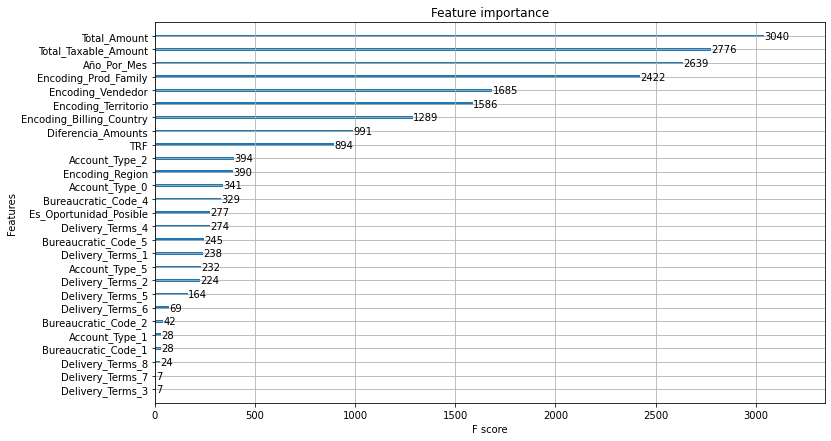

In [305]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)